In [1]:
import numpy as np
import pickle, os, math
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

In [2]:
def interpolate_zero_elements(array):
    # Find the start and end indices where the first and last non-zero elements occur
    first_non_zero_index = np.argmax(array != 0)
    last_non_zero_index = len(array) - 1 - np.argmax(array[::-1] != 0)

    # Isolate the portion of the array that needs interpolation
    inner_array = array[first_non_zero_index:last_non_zero_index + 1]

    # Get the indices of the non-zero elements in the inner array
    non_zero_indices = np.nonzero(inner_array)[0]

    # Get the indices of the zero elements in the inner array
    zero_indices = np.where(inner_array == 0)[0]

    # Interpolate to fill in the zero elements with the nearest non-zero values
    inner_array[zero_indices] = np.interp(zero_indices, non_zero_indices, inner_array[non_zero_indices])

    # Place the interpolated inner array back into the original array
    array[first_non_zero_index:last_non_zero_index + 1] = inner_array
    return array

def process_length_level(sample):
    len_sample = None
    if sample.shape[0]==22:
        len_sample = np.sum(sample, axis=0)
    else:
        len_sample = np.copy(sample)
    processed_sample = np.zeros( len_sample.shape )
    for i in range(len_sample.shape[0]):
        processed_sample[i, :] = interpolate_zero_elements(len_sample[i, :])
    return processed_sample

In [3]:
dic = None
with open('../ref_genome_GC.pkl', 'rb') as f:
    dic = pickle.load(f)
ref_GC_array = dic['GC_array']
ref_len_GC_array = process_length_level(ref_GC_array)

def load_dic(folder):
    dic = {}
    for file_ in os.listdir(folder):
        if file_.endswith('.npy'):
            dic[file_[:-4]] = process_length_level(np.load(folder+'/'+file_))
    return dic

len_whole_dic, len_neutral_dic, len_cnv_dic = load_dic('whole_genome'), load_dic('neutral_regions'), load_dic('cnv_regions')

# General GC Bias

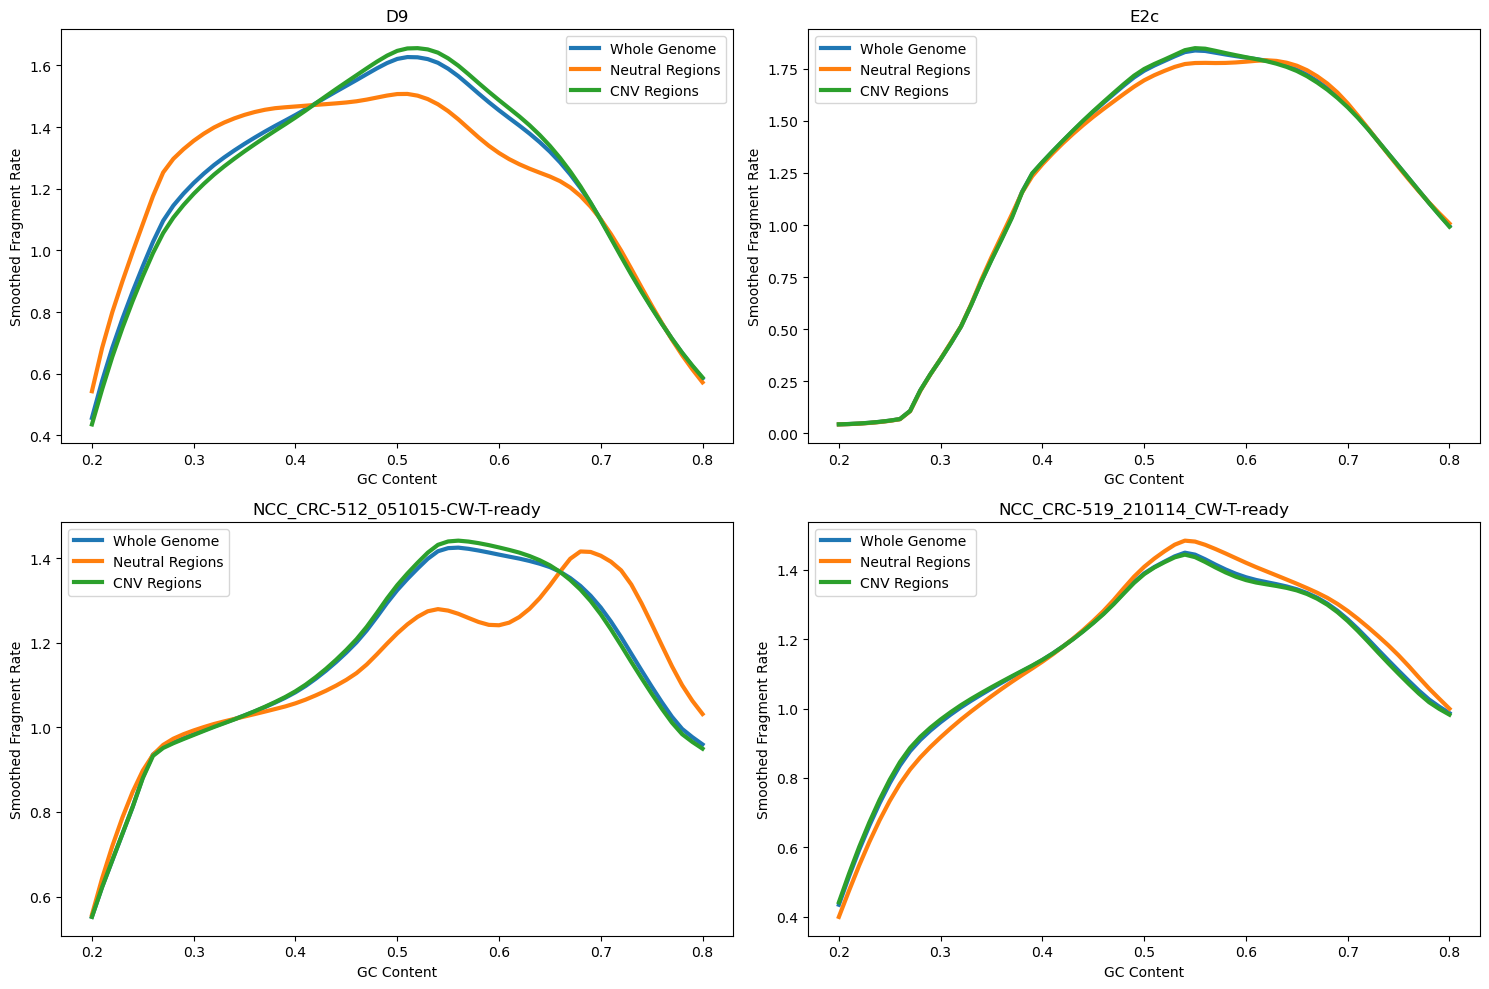

In [4]:
lower_cnt, upper_cnt = 10, 90
thr = 3
X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
lag = 10

def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr

def construct_GC_bias(sample, ref, X):
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.15)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array

def single_bias_plot(sample, label, ax):
    sample = np.sum(sample, axis=0)
    ref_GC_array = np.sum(ref_len_GC_array, axis=0)
    Y = construct_GC_bias(sample, ref_GC_array, X)
    ax.plot(X[lag:-lag], Y[lag:-lag], label=label, linewidth=3)
    

def plot_GC_bias(sample, ax):
    global len_whole_dic, len_neutral_dic, len_cnv_dic, ref_len_GC_array
    single_bias_plot(len_whole_dic[sample], 'Whole Genome', ax)
    single_bias_plot(len_neutral_dic[sample], 'Neutral Regions', ax)
    single_bias_plot(len_cnv_dic[sample], 'CNV Regions', ax)
    ax.set_xlabel('GC Content')
    ax.set_ylabel('Smoothed Fragment Rate')
    ax.legend()
    ax.set_title(sample)
    # ax.set_ylim(bottom=0)
    
    
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
i = 0
for key in len_whole_dic.keys():
    row = i // 2  # Determine the row index
    col = i % 2   # Determine the column index
    plot_GC_bias(key, axes[row, col])
    i += 1
plt.tight_layout()
plt.show()

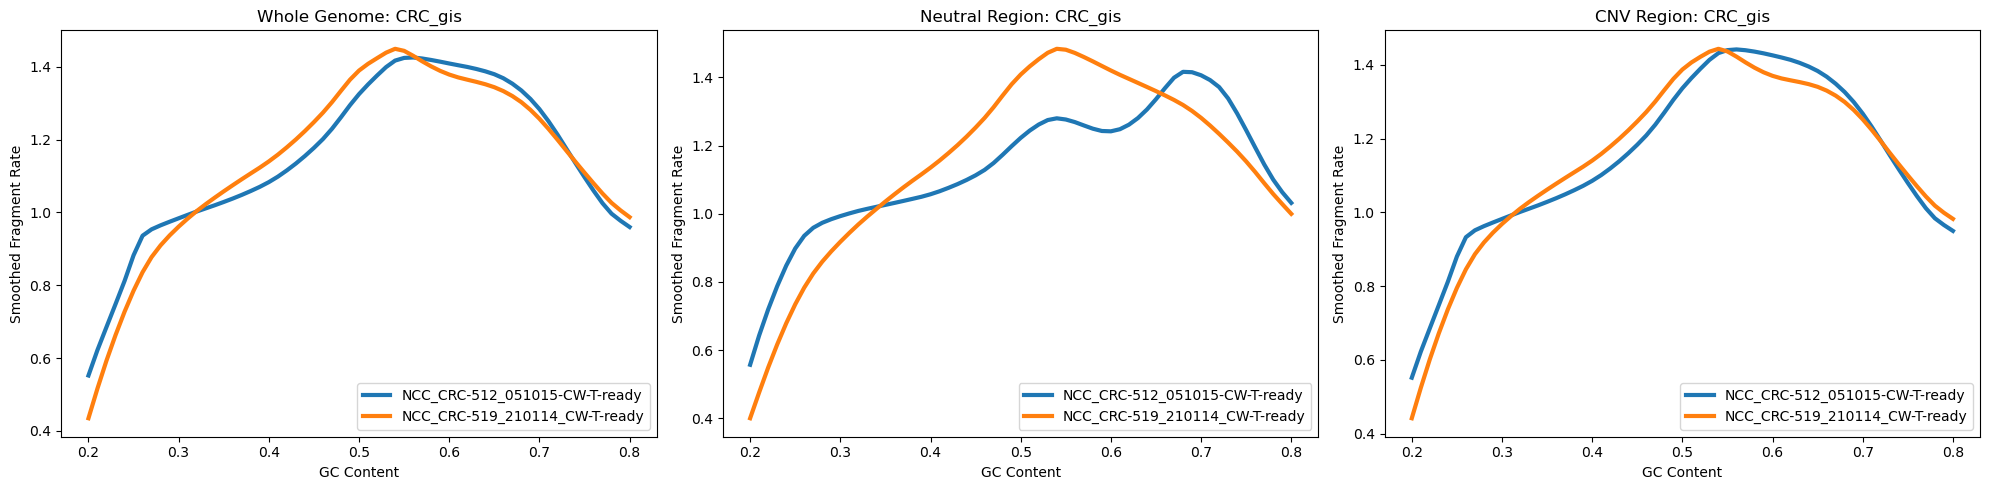

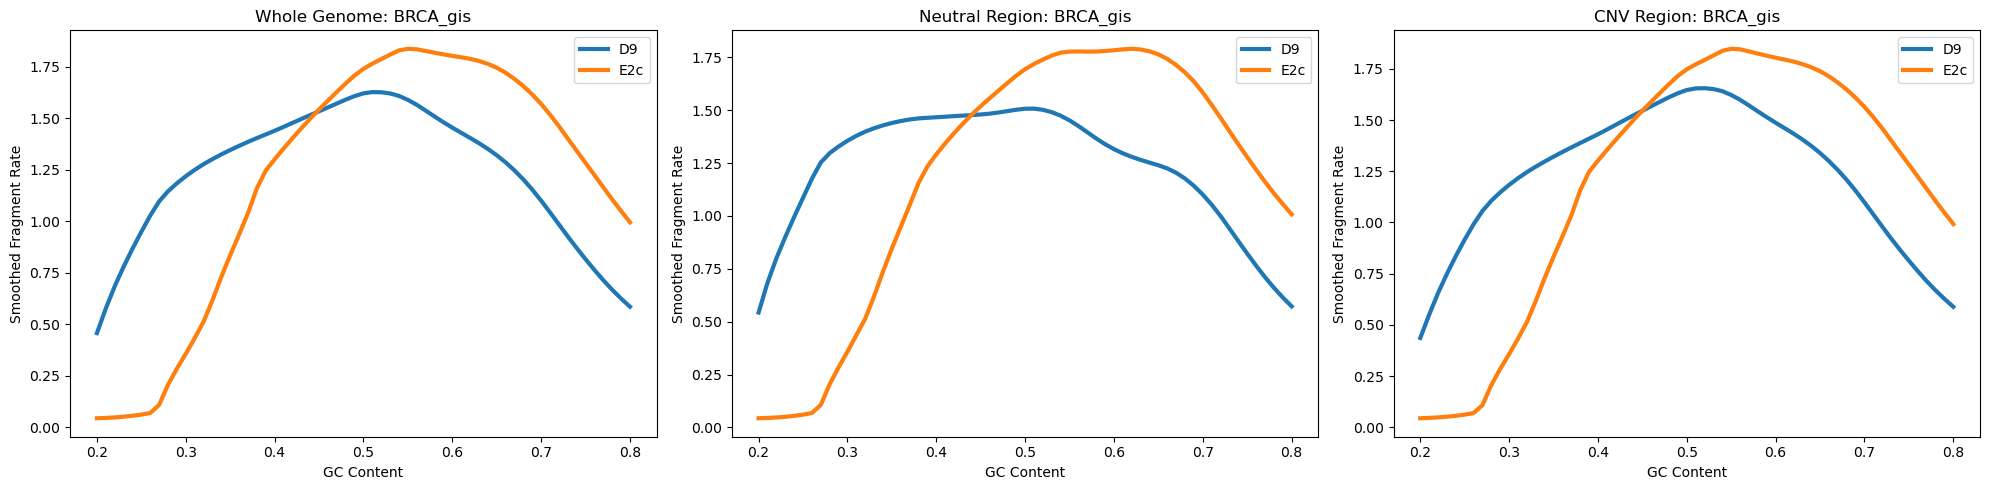

In [5]:
lower_cnt, upper_cnt = 10, 90
thr = 3
X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
lag = 10

def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr

def construct_GC_bias(sample, ref, X):
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.15)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array

def single_bias_plot(sample, label, ax):
    sample = np.sum(sample, axis=0)
    ref_GC_array = np.sum(ref_len_GC_array, axis=0)
    Y = construct_GC_bias(sample, ref_GC_array, X)
    ax.plot(X[lag:-lag], Y[lag:-lag], label=label, linewidth=3)
    
def plot_cohort_GC_bias(is_NCC, sample_len_dic, title, ax):
    global ref_len_GC_array
    for key in sample_len_dic.keys():
        if is_NCC==True and ('NCC' in key):
            single_bias_plot(sample_len_dic[key], key, ax)
        elif is_NCC==False and ('NCC' not in key):
            single_bias_plot(sample_len_dic[key], key, ax)
    ax.set_xlabel('GC Content')
    ax.set_ylabel('Smoothed Fragment Rate')
    ax.legend()
    ax.set_title(title)
    
def get_cohort_GC_bias(is_NCC, cohort_name):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    i = 0
    plot_cohort_GC_bias(is_NCC, len_whole_dic, f'Whole Genome: {cohort_name}', axes[0])
    plot_cohort_GC_bias(is_NCC, len_neutral_dic, f'Neutral Region: {cohort_name}', axes[1])
    plot_cohort_GC_bias(is_NCC, len_cnv_dic, f'CNV Region: {cohort_name}', axes[2])
    plt.tight_layout()
    plt.show()

get_cohort_GC_bias(True, 'CRC_gis')
get_cohort_GC_bias(False, 'BRCA_gis')

# Fragment Group GC Bias

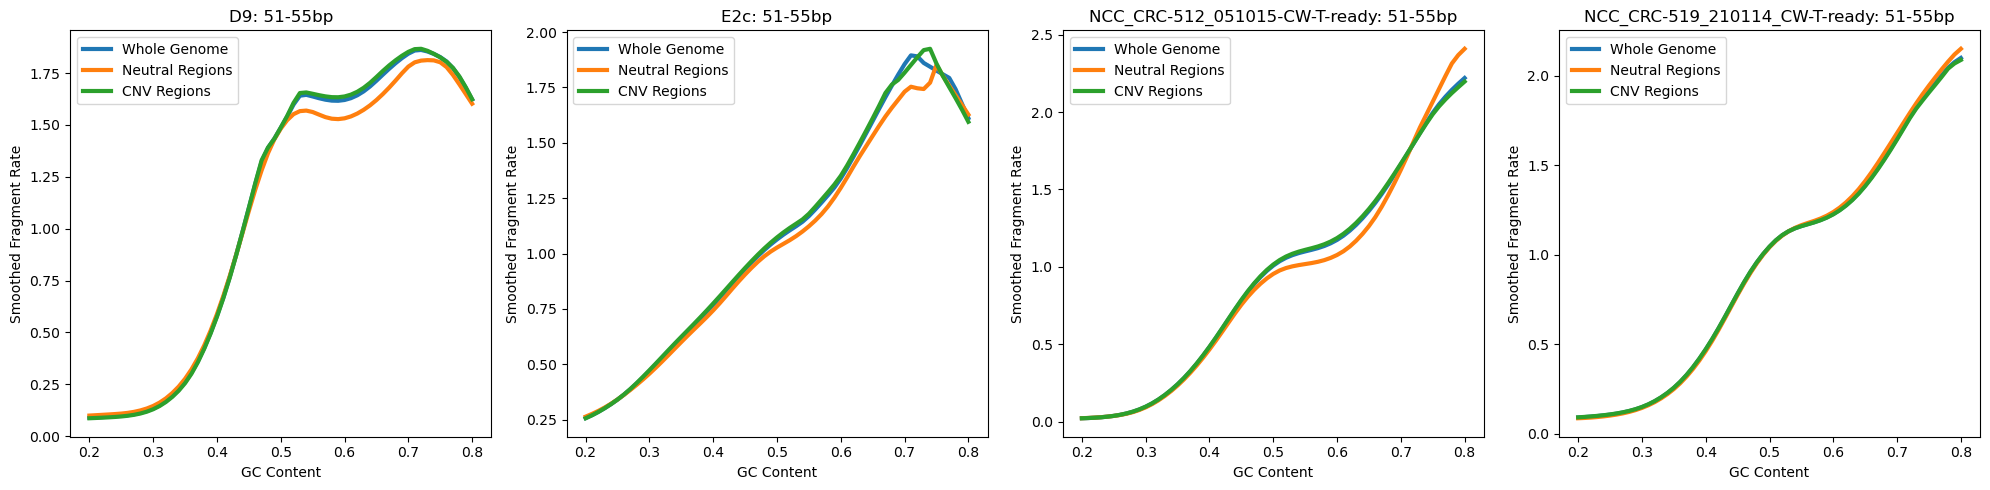

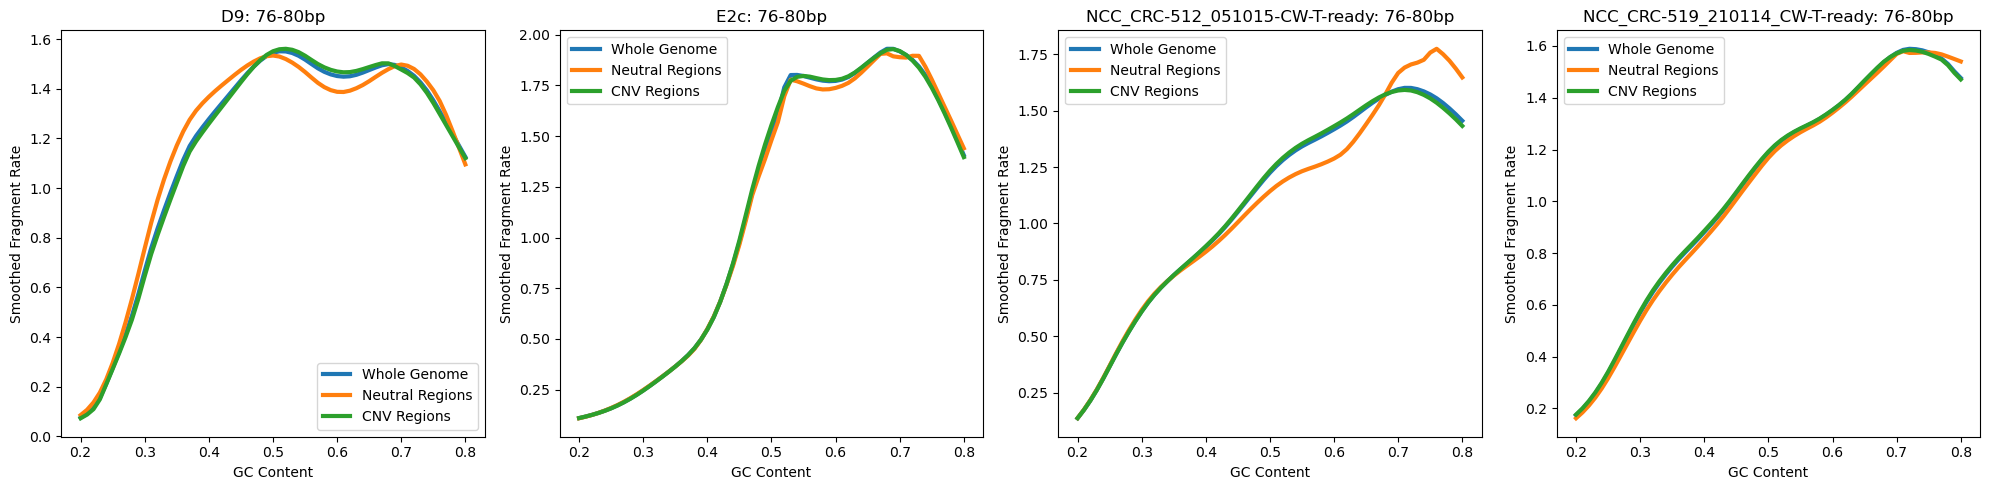

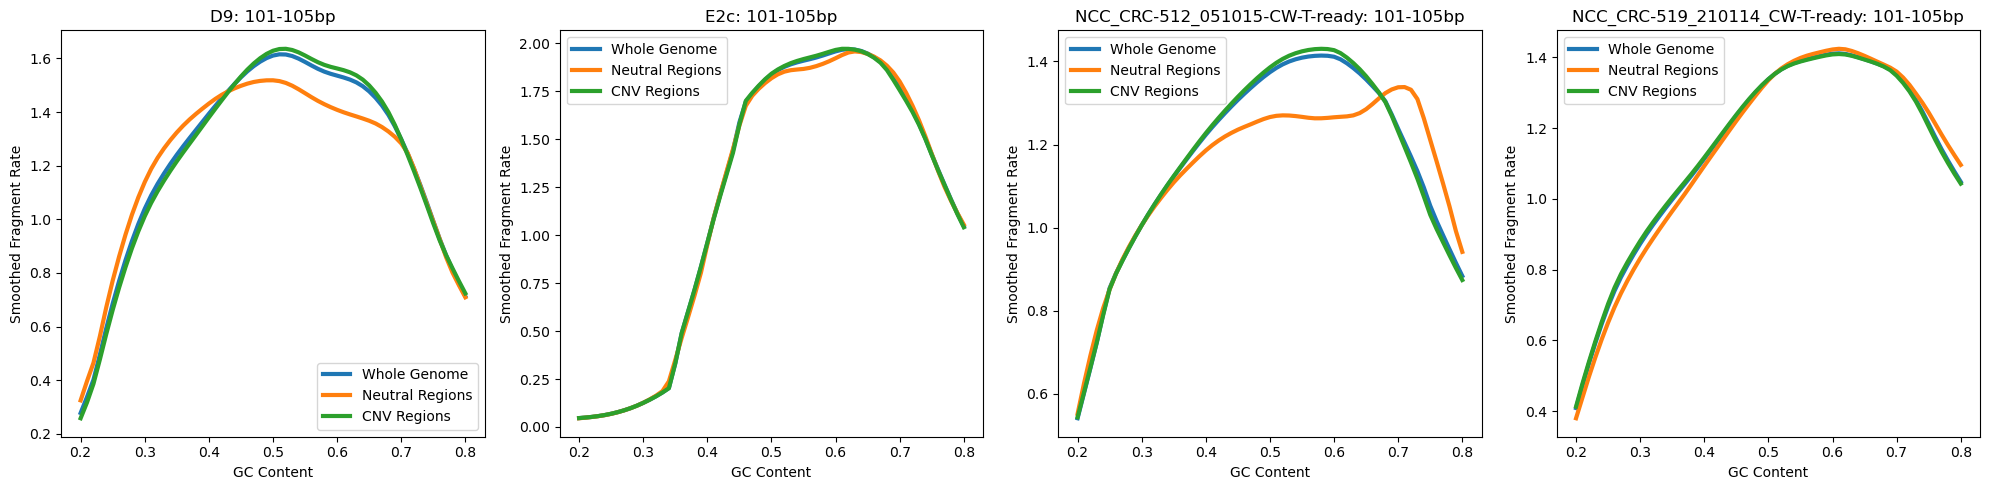

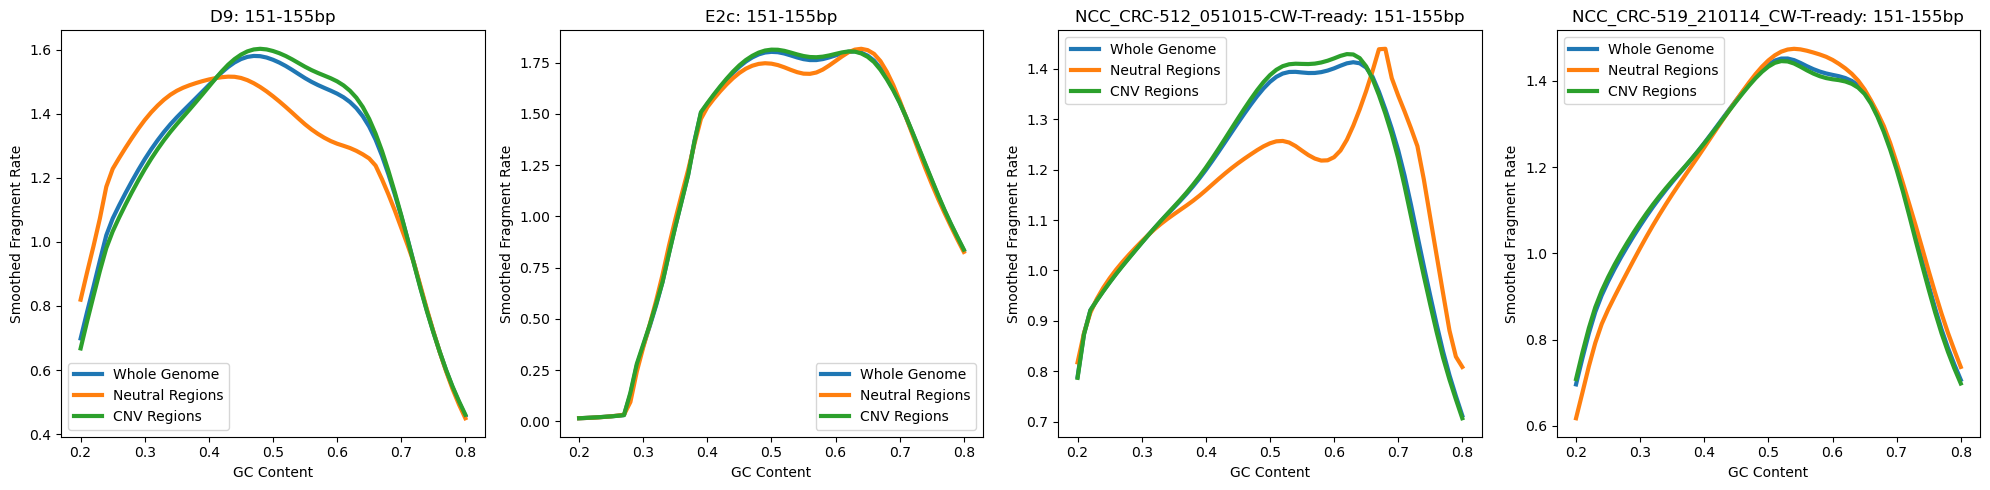

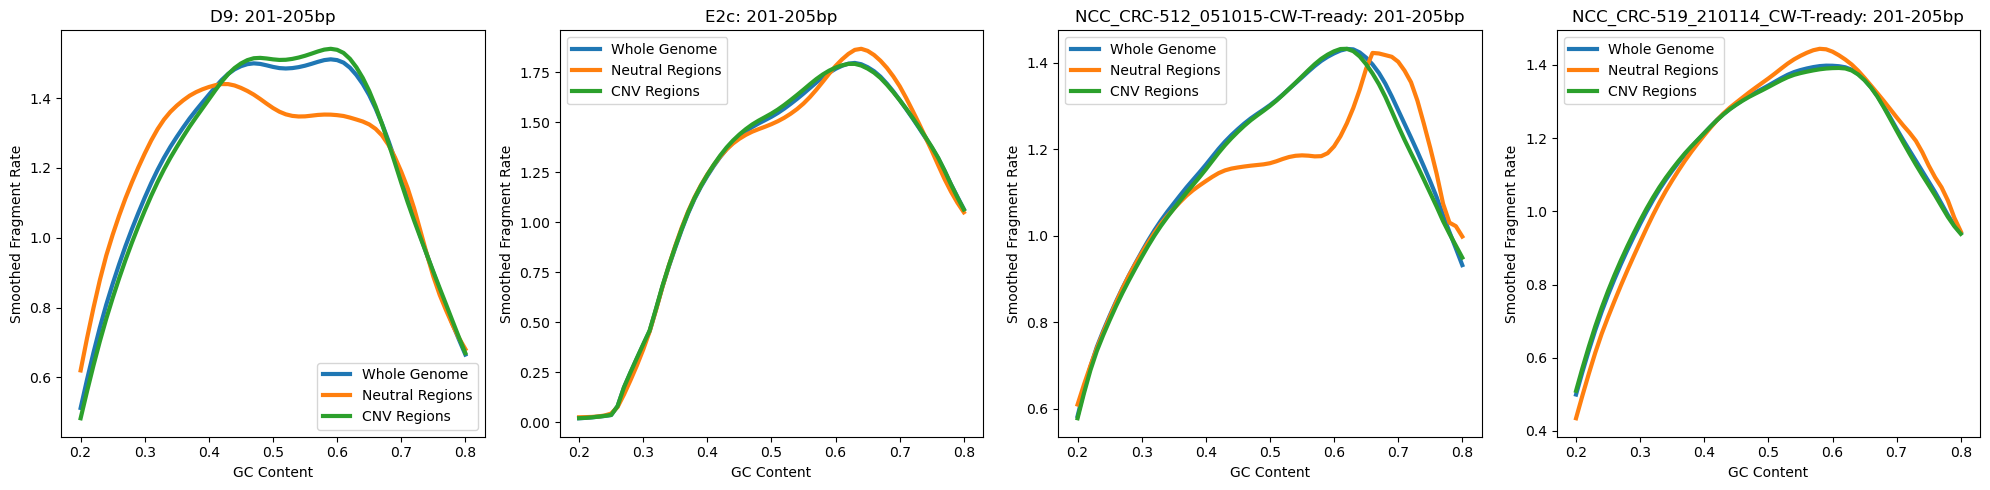

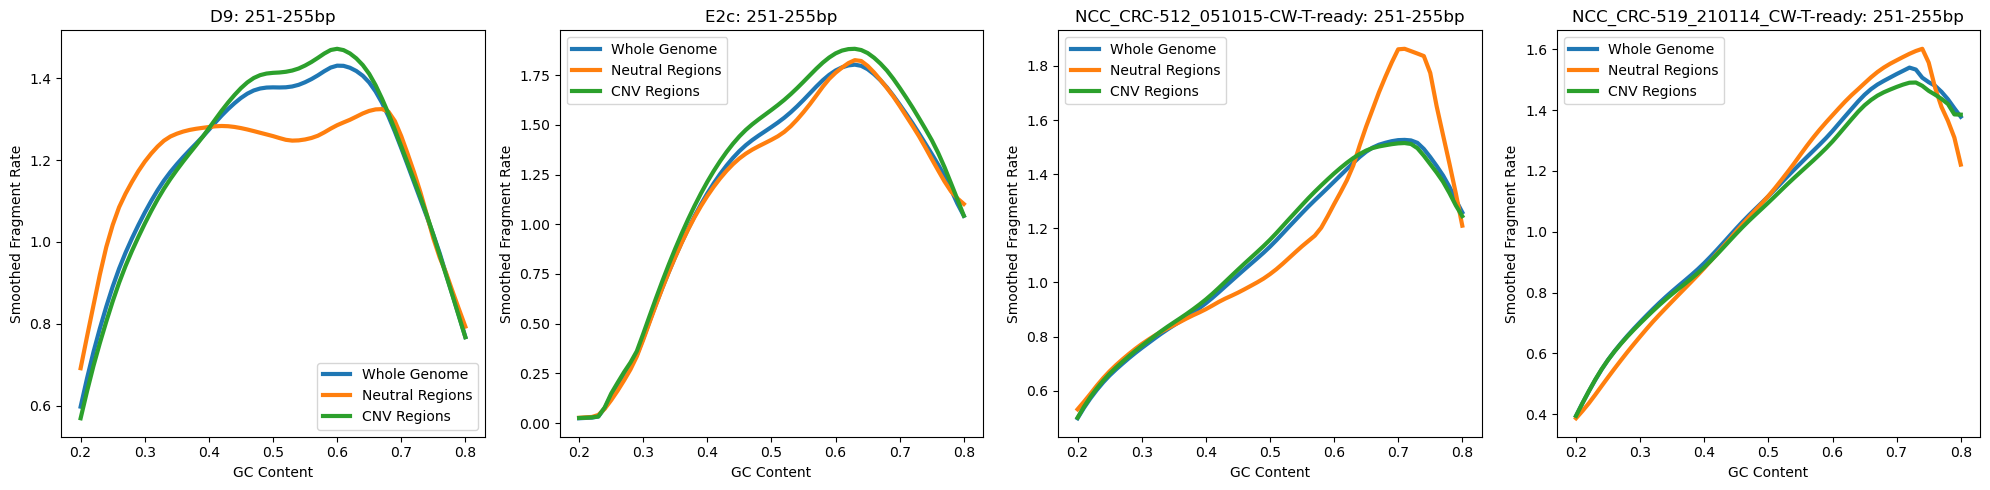

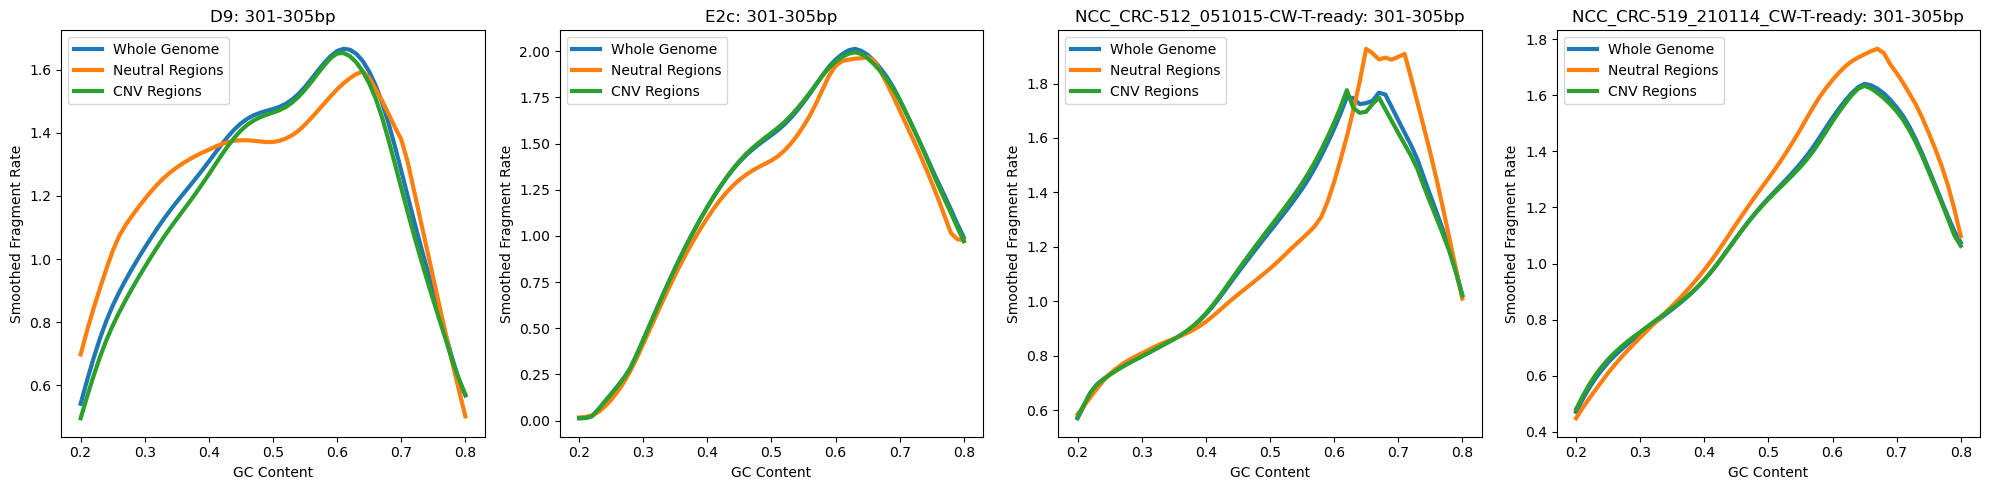

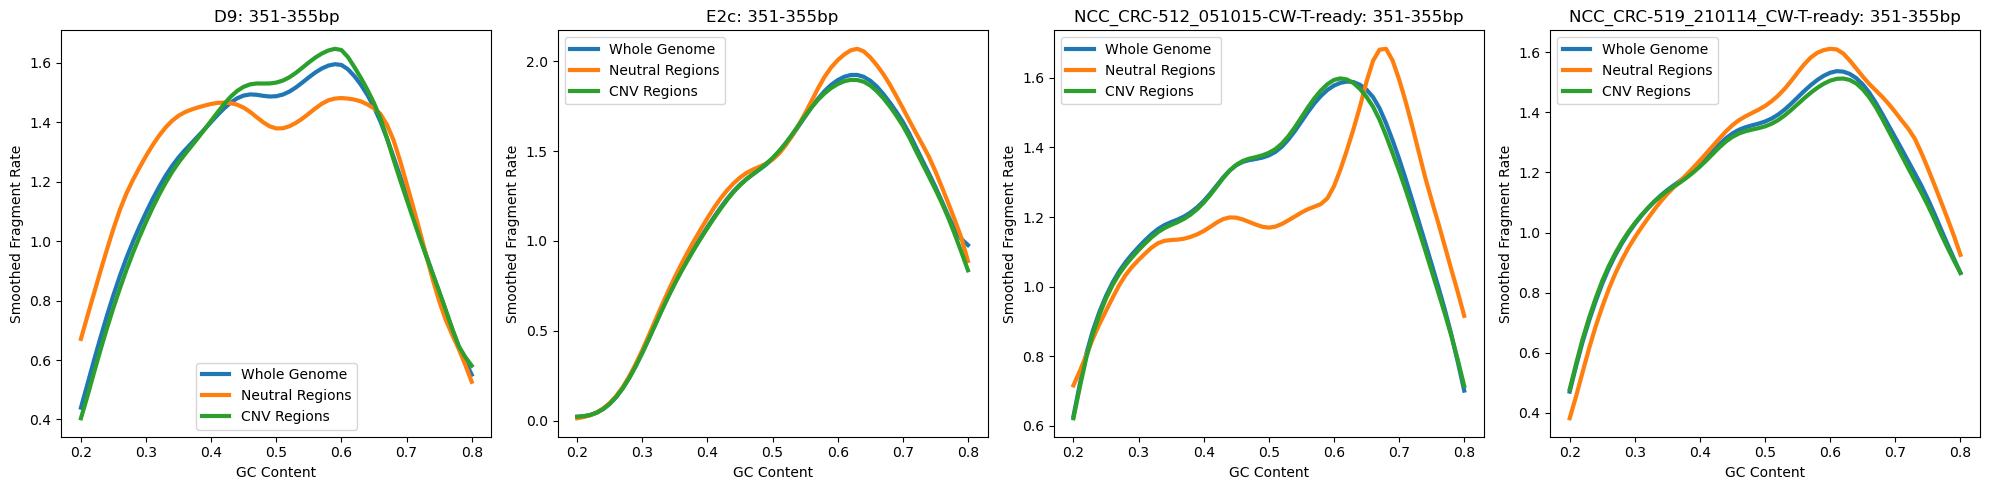

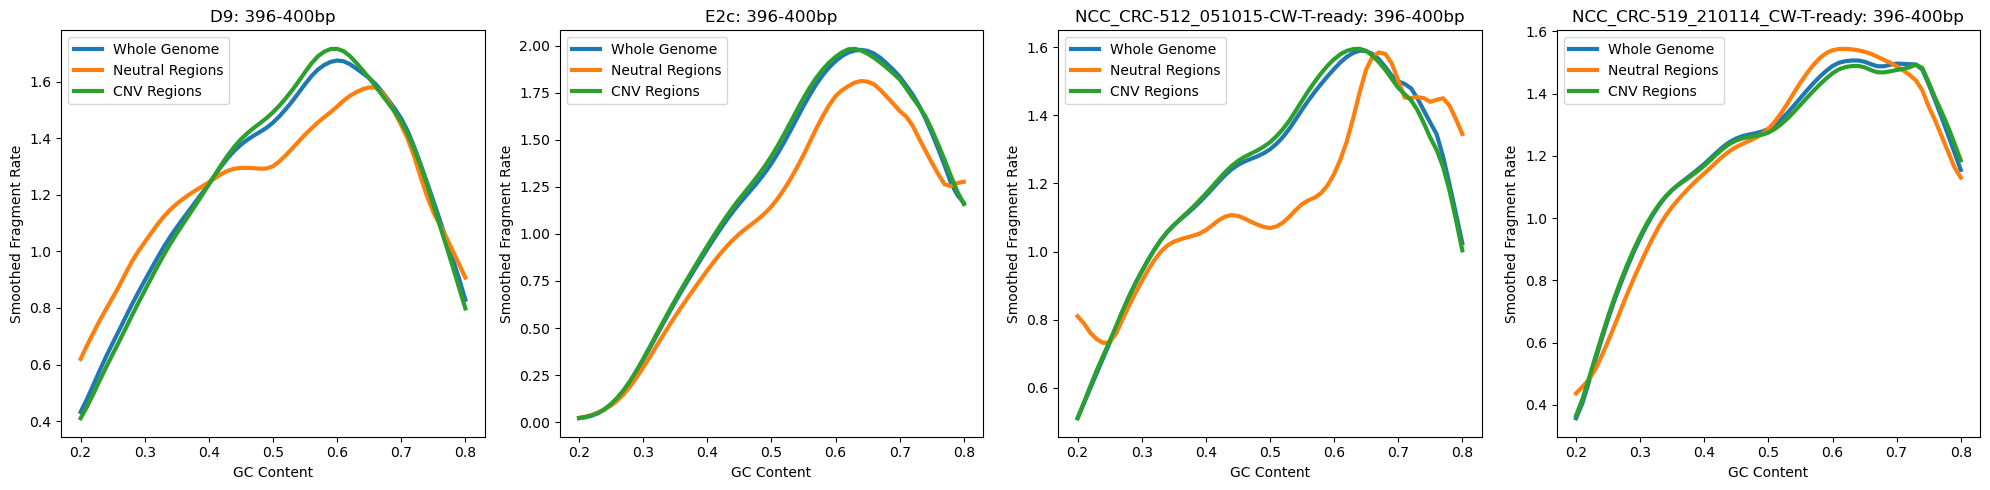

In [6]:
lower_cnt, upper_cnt = 10, 90
window_size = 5
thr = 3
X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
lag = 10

def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr 

def construct_GC_bias(sample, ref, X):
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.15)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array

def single_bias_plot(sample, label, frag_len, ax):
    start_len_ind = frag_len - 51
    end_len_ind = start_len_ind + window_size - 1
    sample = np.sum(sample[start_len_ind: end_len_ind+1], axis=0)
    ref_GC_array = np.sum(ref_len_GC_array[start_len_ind: end_len_ind+1], axis=0)
    Y = construct_GC_bias(sample, ref_GC_array, X)
    ax.plot(X[lag:-lag], Y[lag:-lag], label=label, linewidth=3)


def plot_len_GC_bias(sample, frag_len, ax):
    global len_whole_dic, len_neutral_dic, len_cnv_dic, ref_len_GC_array
    single_bias_plot(len_whole_dic[sample], 'Whole Genome', frag_len, ax)
    single_bias_plot(len_neutral_dic[sample], 'Neutral Regions', frag_len, ax)
    single_bias_plot(len_cnv_dic[sample], 'CNV Regions', frag_len, ax)
    ax.set_xlabel('GC Content')
    ax.set_ylabel('Smoothed Fragment Rate')
    ax.legend()
    ax.set_title(f'{sample}: {frag_len}-{frag_len + window_size - 1}bp')
    

def get_len_bias(frag_len):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    i = 0
    for key in len_whole_dic.keys():
        plot_len_GC_bias(key, frag_len, axes[i])
        i+=1
    plt.tight_layout()
    plt.show()
    
lengths = [51, 76, 101, 151, 201, 251, 301, 351, 396]
for length in lengths:
    get_len_bias(length)

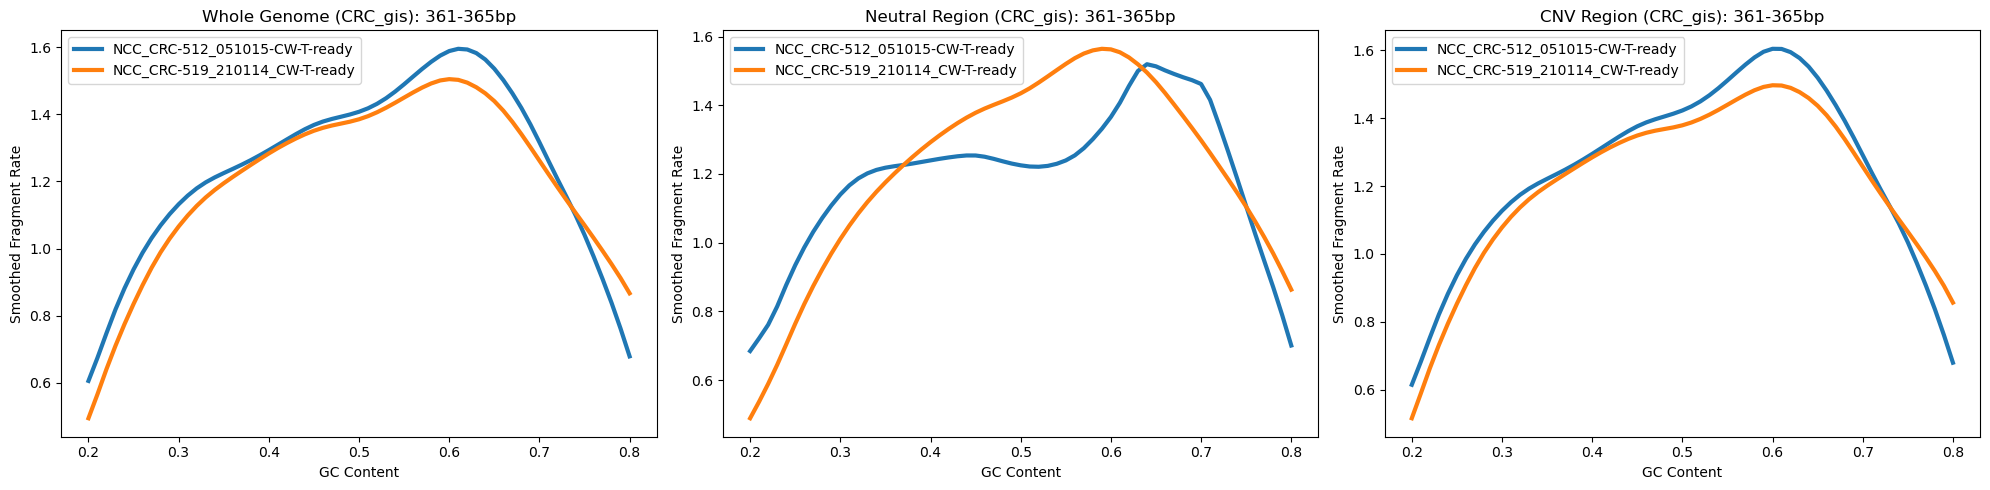

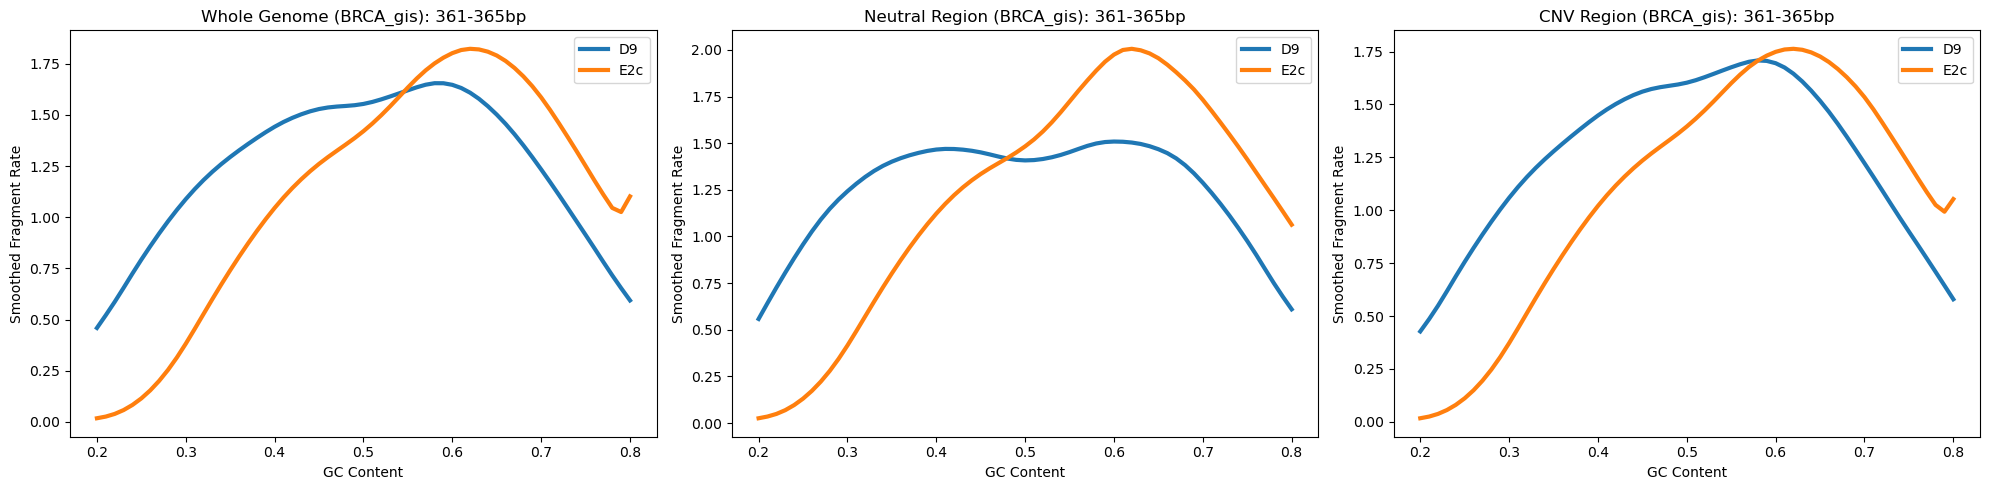

-----------------------------------------------------------------------------------------------------------------------


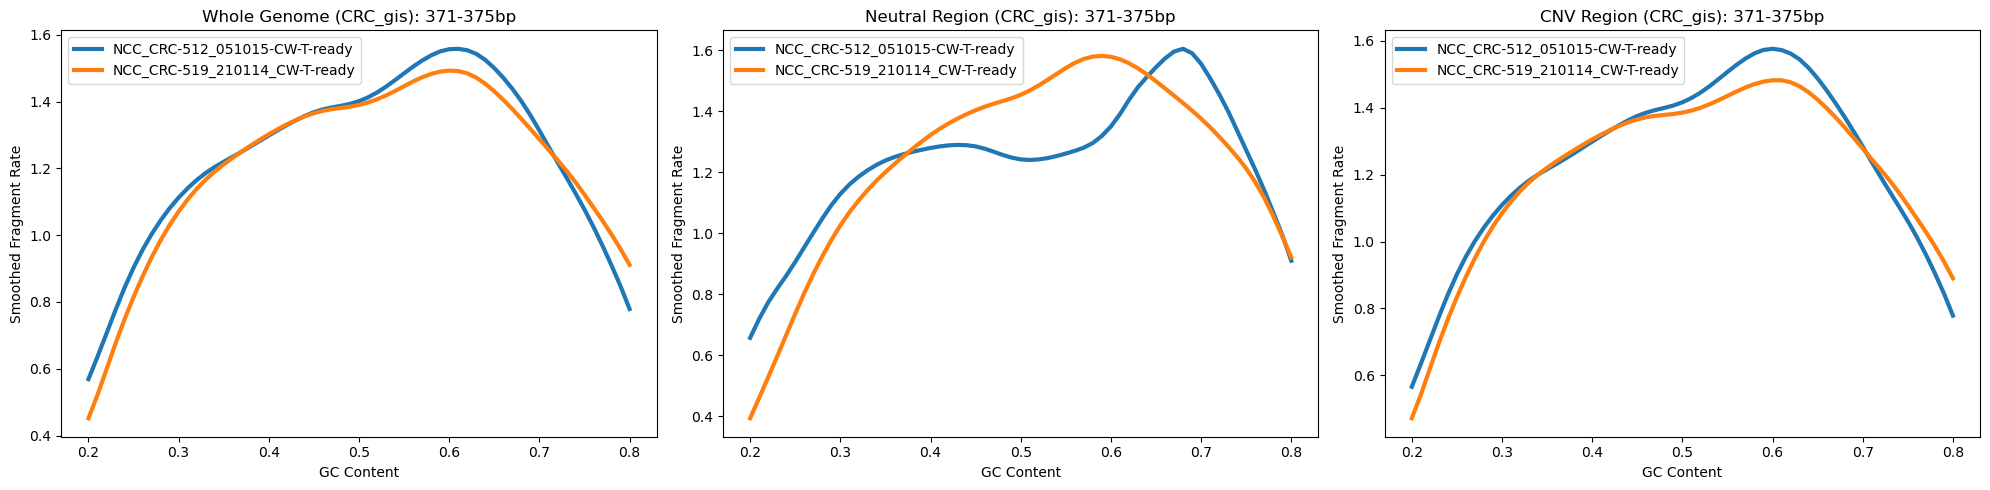

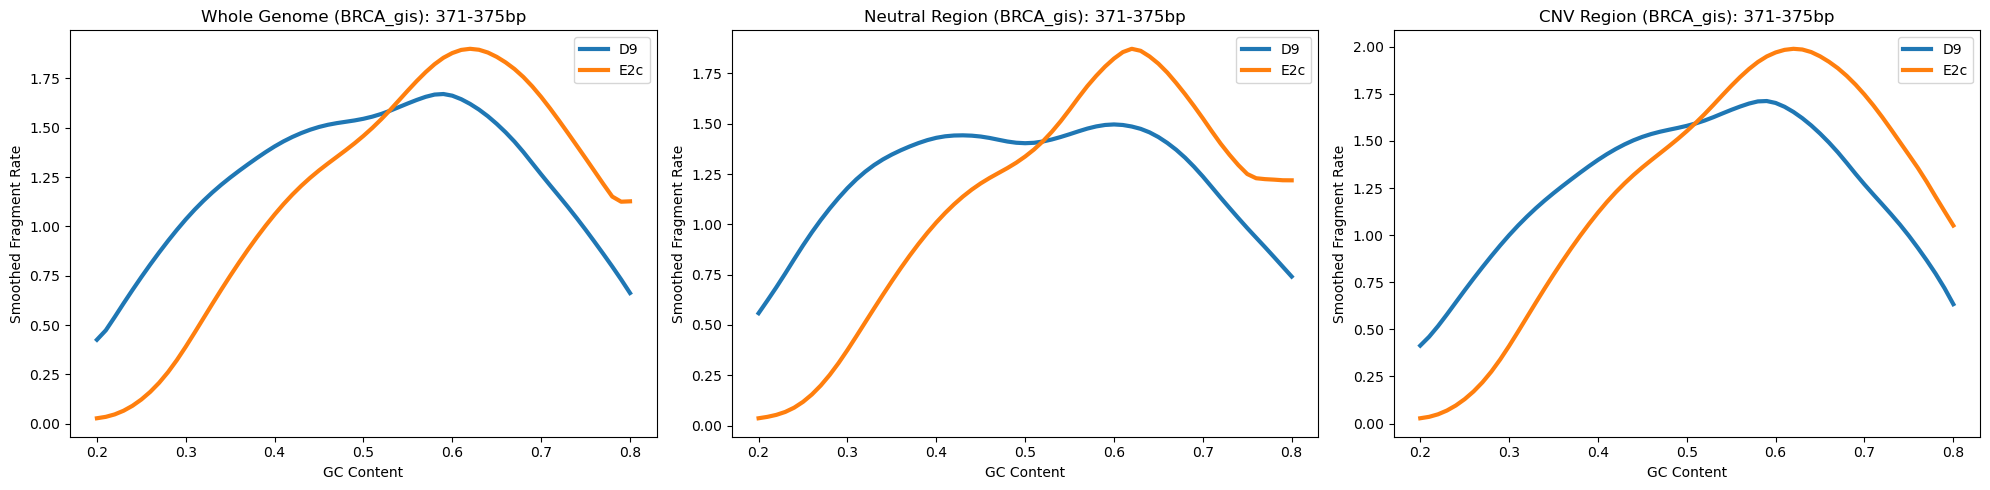

-----------------------------------------------------------------------------------------------------------------------


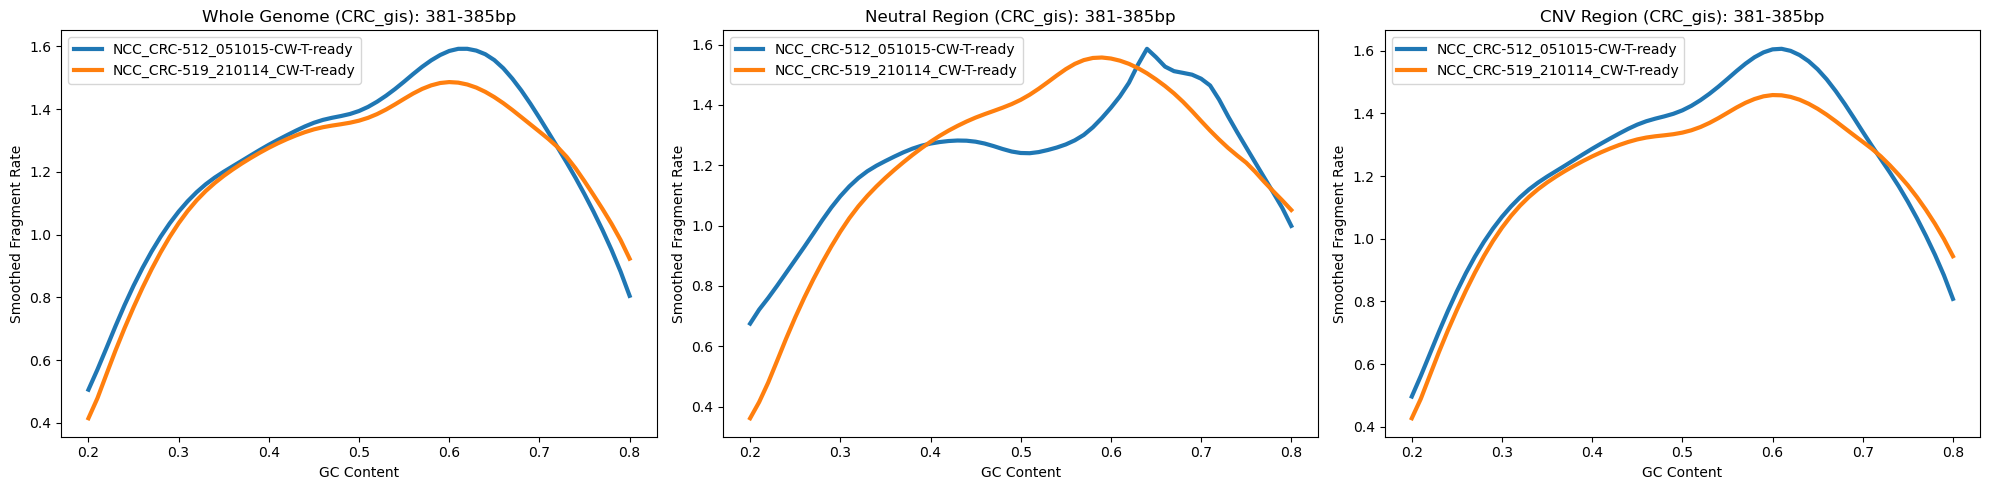

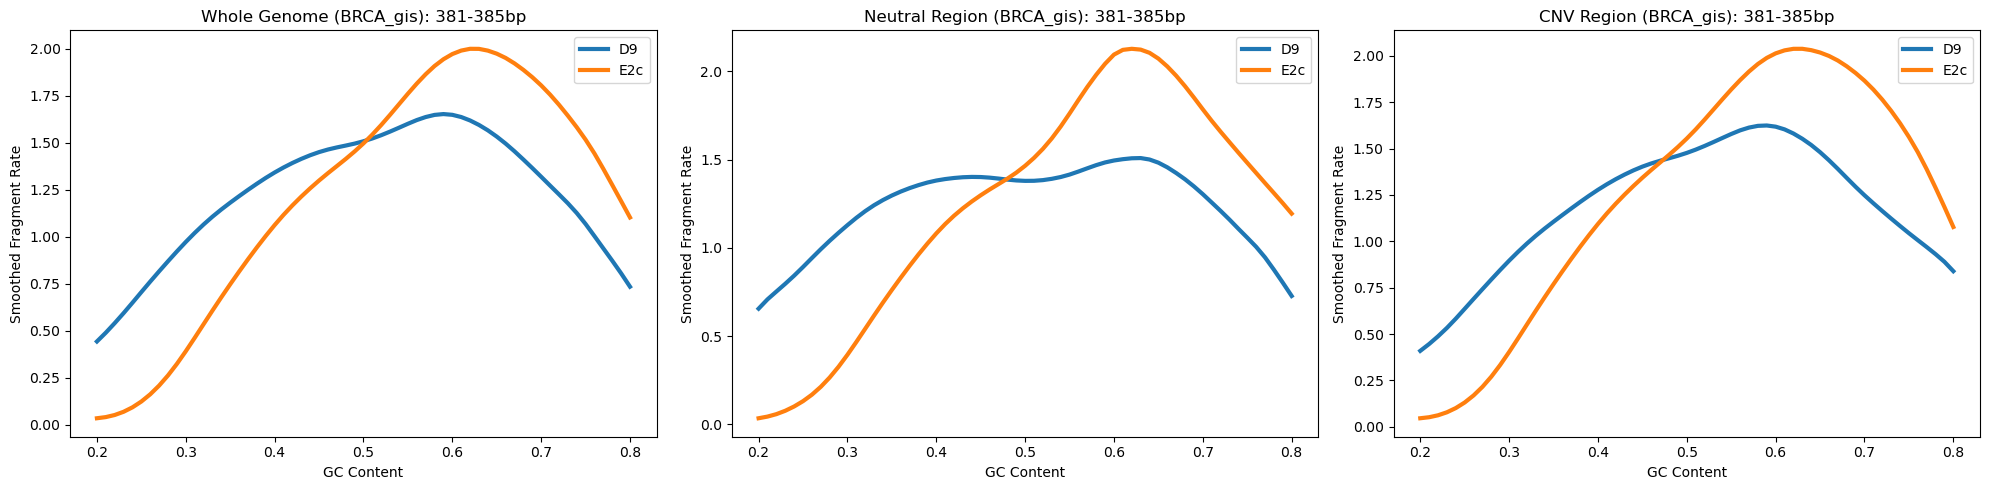

-----------------------------------------------------------------------------------------------------------------------


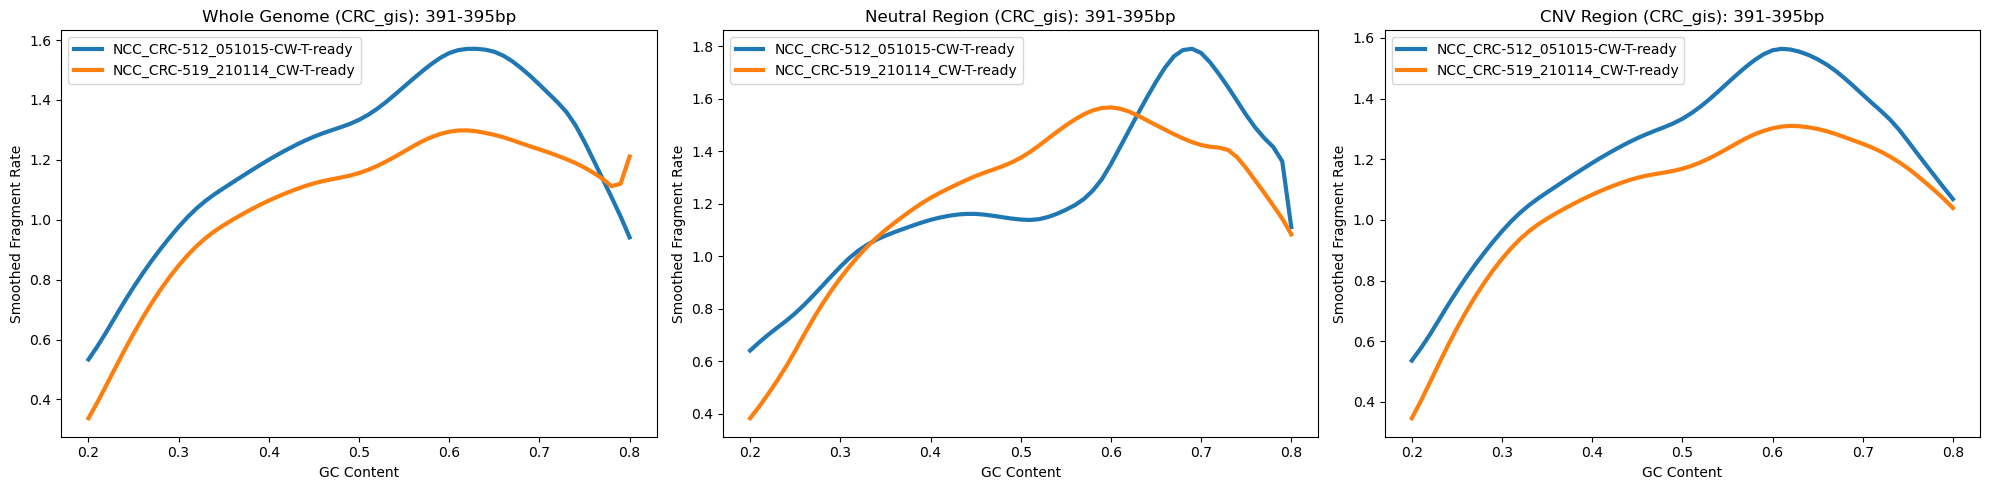

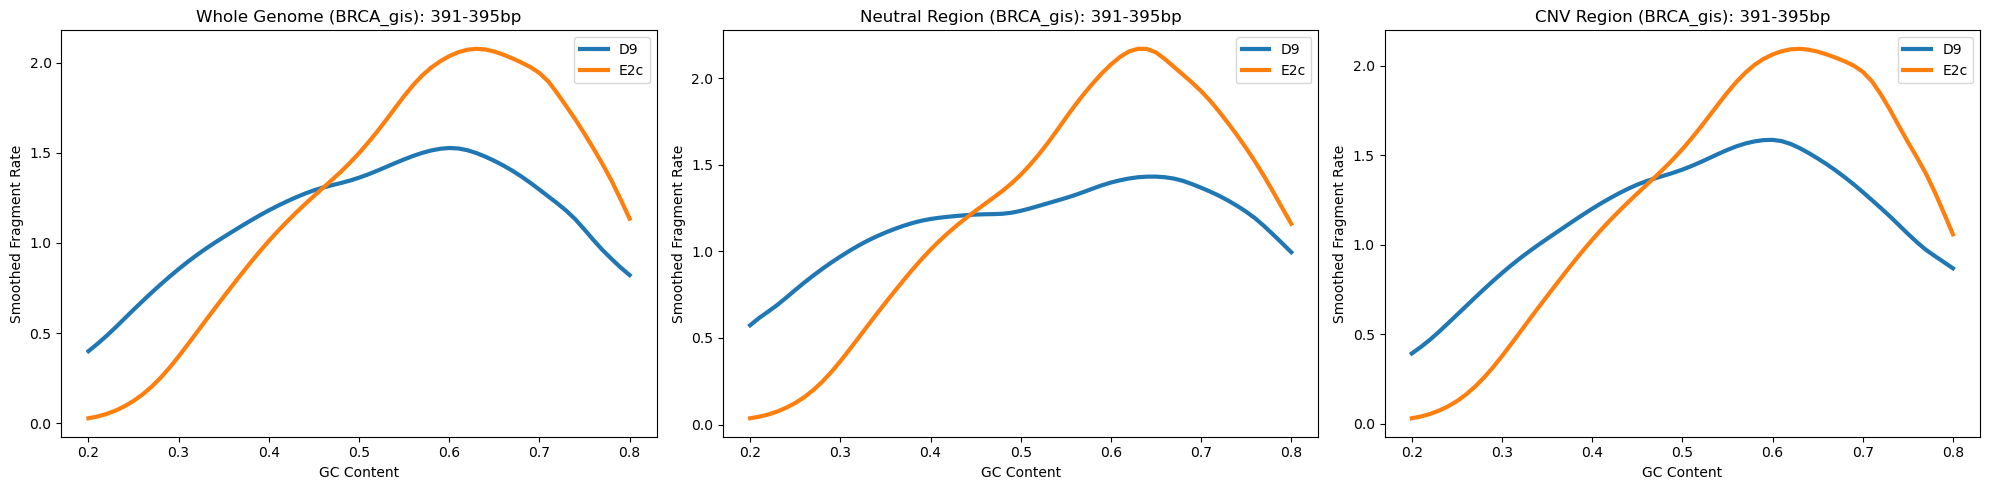

-----------------------------------------------------------------------------------------------------------------------


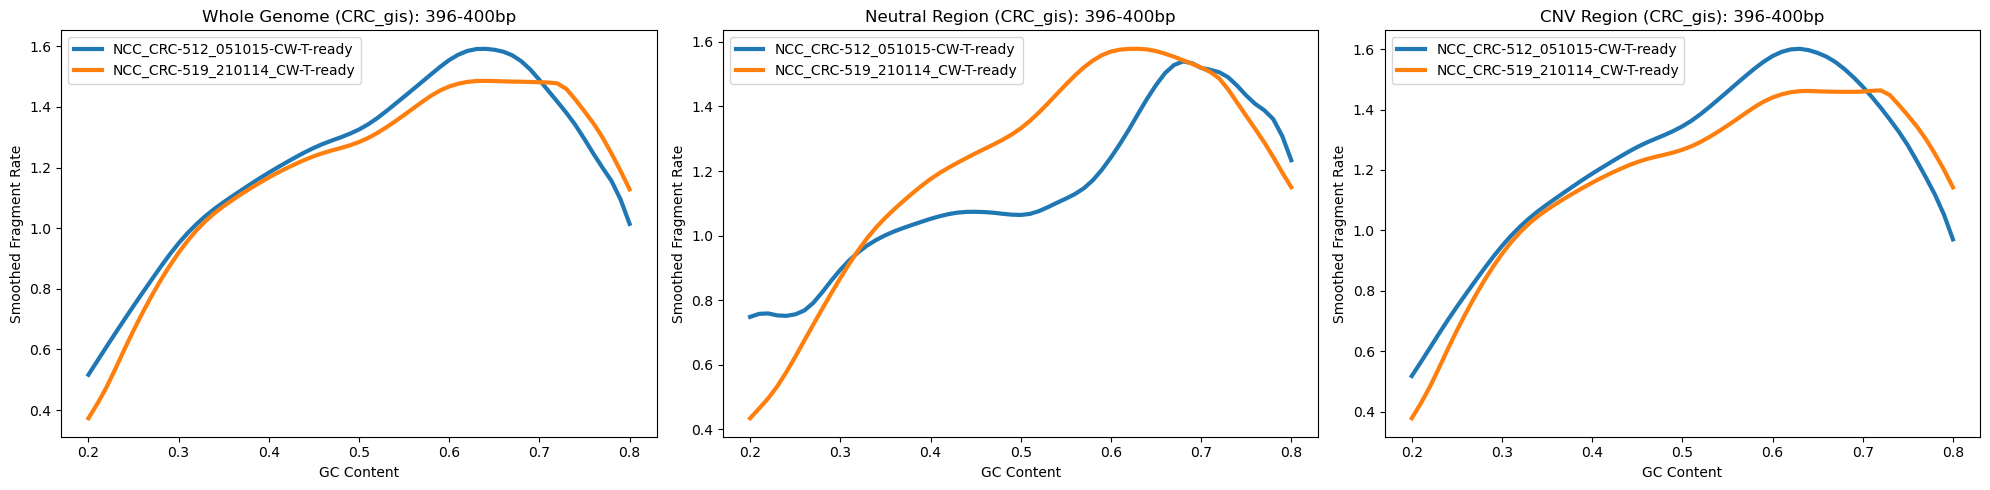

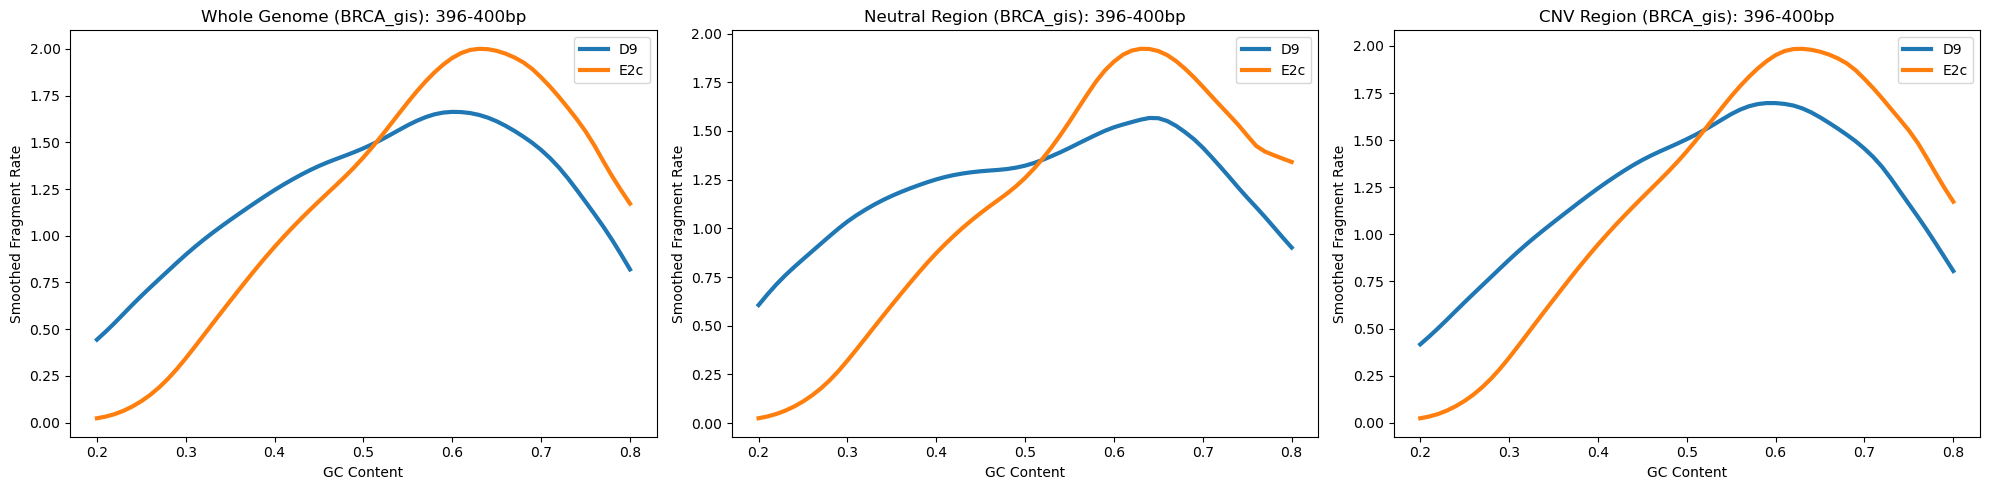

-----------------------------------------------------------------------------------------------------------------------


In [7]:
lower_cnt, upper_cnt = 10, 90
window_size = 5
thr = 3
X = [float(i/100) for i in range(lower_cnt, upper_cnt+1)]
lag = 10

def remove_outlier(arr):
    high = np.percentile(arr, 100-thr)
    low = np.percentile(arr, thr)
    arr = np.where(arr>high, high, arr)
    arr = np.where(arr<low, low, arr)
    return arr 

def construct_GC_bias(sample, ref, X):
    safe_ref = np.where(ref == 0, 1, ref)
    GC_array = sample / safe_ref
    GC_array = GC_array[lower_cnt: upper_cnt+1]
    GC_array = remove_outlier(GC_array)
    GC_array = GC_array / np.mean(GC_array)
    lowess = sm.nonparametric.lowess(GC_array, X, frac=0.2)
    GC_array = lowess[:, 1]
    GC_array = GC_array / np.mean(GC_array)
    return GC_array

def single_bias_plot(sample, label, frag_len, ax):
    start_len_ind = frag_len - 51
    end_len_ind = start_len_ind + window_size - 1
    sample = np.sum(sample[start_len_ind: end_len_ind+1], axis=0)
    ref_GC_array = np.sum(ref_len_GC_array[start_len_ind: end_len_ind+1], axis=0)
    Y = construct_GC_bias(sample, ref_GC_array, X)
    ax.plot(X[lag:-lag], Y[lag:-lag], label=label, linewidth=3)


def plot_len_GC_bias(is_NCC, sample_len_dic, frag_len, title, ax):
    global ref_len_GC_array
    for key in sample_len_dic.keys():
        if is_NCC==True and ('NCC' in key):
            single_bias_plot(sample_len_dic[key], key, frag_len, ax)
        elif is_NCC==False and ('NCC' not in key):
            single_bias_plot(sample_len_dic[key], key, frag_len, ax)
    ax.set_xlabel('GC Content')
    ax.set_ylabel('Smoothed Fragment Rate')
    ax.legend()
    ax.set_title(title)
    

def get_cohort_len_bias(is_NCC, frag_len, cohort_name):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plot_len_GC_bias(is_NCC, len_whole_dic, frag_len, 
                     f'Whole Genome ({cohort_name}): {frag_len}-{frag_len + window_size - 1}bp', axes[0])
    plot_len_GC_bias(is_NCC, len_neutral_dic, frag_len, 
                     f'Neutral Region ({cohort_name}): {frag_len}-{frag_len + window_size - 1}bp', axes[1])
    plot_len_GC_bias(is_NCC, len_cnv_dic, frag_len, 
                     f'CNV Region ({cohort_name}): {frag_len}-{frag_len + window_size - 1}bp', axes[2])
    plt.tight_layout()
    plt.show()


lengths = [361, 371, 381, 391, 396]
for length in lengths:
    get_cohort_len_bias(True, length, 'CRC_gis')
    get_cohort_len_bias(False, length, 'BRCA_gis')
    print('-----------------------------------------------------------------------------------------------------------------------')